In [5]:
# -*- coding: utf-8 -*-
import os
import torch
import numpy as np
from torch.utils.data import Subset
import pandas as pd

import prepare_data as prepare_data
import partition_data as partition_data
import create_ood_test as create_ood_test

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'

In [6]:
# Hyperparameters.
data_type = "imagenet"  # imagenet32
data_path = os.getcwd()
local_tr_ratio, local_te_ratio = 0.6, 0.2
non_iid_alpha = 0.01
seed = 6
random_state = np.random.RandomState(seed)
num_clients = 20
corr_severity = 5

# Sanity check.
assert local_tr_ratio > 0 and local_te_ratio >= 0

dataset = {}
if data_type == "imagenet":

    # Prepare dataset.
    dataset["imagenet_tr"] = prepare_data.get_dataset(
        data_name="imagenet32", datasets_path=data_path, split="train",
    )
    dataset["imagenet_te"] = prepare_data.get_dataset(
        data_name="imagenet32", datasets_path=data_path, split="test",
    )

    # Merge, then split.
    fl_data = torch.utils.data.ConcatDataset([dataset["imagenet_tr"], dataset["imagenet_te"]])
    fl_data.indices = list(range(len(dataset["imagenet_tr"]) + len(dataset["imagenet_te"])))
    fl_data.targets = dataset["imagenet_tr"].targets + dataset["imagenet_te"].targets

    non_iid_indices = partition_data.inter_client_non_iid_partition(
        fl_data, non_iid_alpha, random_state, num_clients
    )

    # Intra-split into local train/val/test.
    indices_per_client = partition_data.intra_client_uniform_partition(
        non_iid_indices, random_state, local_tr_ratio, local_te_ratio
    )

    # Create ID/OOD train & test datasets.
    fl_data_per_client = {}
    fl_data_per_client["train"], fl_data_per_client["val"], fl_data_per_client["test"] = {}, {}, {}
    for i, indices in indices_per_client.items():
        fl_data_per_client["train"][i] = Subset(fl_data, indices["train"])
        fl_data_per_client["val"][i] = Subset(fl_data, indices["val"])
        fl_data_per_client["test"][i] = Subset(fl_data, indices["test"])
    fl_data_per_client["a_test"] = create_ood_test.get_natural_shift_data(
        fl_data,
        indices_per_client,
        random_state,
        data_path=data_path,
        data_name="imagenet_a",
    )  # ImageNet-A
    fl_data_per_client["v2_test"] = create_ood_test.get_natural_shift_data(
        fl_data,
        indices_per_client,
        random_state,
        data_path=data_path,
        data_name="imagenet_v2_matched-frequency",
    )  # ImageNet-V2
    fl_data_per_client["r_test"] = create_ood_test.get_natural_shift_data(
        fl_data,
        indices_per_client,
        random_state,
        data_path=data_path,
        data_name="imagenet_r",
    )  # ImageNet-R
    fl_data_per_client["mixed_test"] = create_ood_test.get_mixed_data(
        fl_data_per_client,
        random_state,
    )  # mixed test
else:
    raise NotImplementedError

Using downloaded and verified file: /datasets/home/liang/BRFL1/imagenet_a/imagenet-a.tar
Files already downloaded, verified, and uncompressed.
Using downloaded and verified file: /datasets/home/liang/BRFL1/imagenet_v2_matched-frequency/imagenetv2-matched-frequency.tar.gz
Files already downloaded, verified, and uncompressed.
Using downloaded and verified file: /datasets/home/liang/BRFL1/imagenet_r/imagenet-r.tar
Files already downloaded, verified, and uncompressed.


In [18]:
mapcls = pd.read_csv('imagenet_resource/mapcls.txt', header = None)  # https://github.com/PatrykChrabaszcz/Imagenet32_Scripts/blob/master/map_clsloc.txt
overlapping_cls = [446, 387, 389, 398, 399, 464, 472, 603, 608, 611, 411, 415, 417, 418, 420, 213, 647, 653, 620, 425, 426, 439, 14, 173, 125, 64, 211, 143, 62, 190, 622, 629, 630, 224, 631, 634, 635, 639, 643, 225, 188, 13, 53, 165, 44, 137, 455, 223, 265, 683, 258, 908, 733, 817, 851, 591, 239, 701, 227, 269, 871, 942, 219, 876, 751, 355, 962, 221, 600, 263, 247, 250, 831, 975, 993, 885, 737, 743, 735, 746, 320, 323, 326, 362, 954, 327]
IMAGENET_CLASSES = [mapcls.iloc[cls-1][0].split(' ')[-1] for cls in overlapping_cls]

SPLITS=["train", "val", "test", "a_test", "v2_test", "r_test", "mixed_test"]
TITLE={
    "train": "Train",
    "val": "Validation", 
    "test": "Test (in-distribution)", 
    "a_test": "ImageNet-A test", 
    "v2_test": "ImageNet-V2 test", 
    "r_test": "ImageNet-R test" , 
    "mixed_test": "Mixture of ID/OOD tests",
    }

def plot_train_test_split(client_id):

    for split in SPLITS:
        data = fl_data_per_client[split][client_id]
        targets = [s[1] for s in data]
        cls, counts = np.unique(targets, return_counts=True)
        print(f"{split}: client {client_id} has class {list(cls)} with counts {list(counts)}")

    for split in SPLITS:
        data = fl_data_per_client[split][client_id]

        f, axes = plt.subplots(1, 10, figsize=(14, 2))
        plt.suptitle(f"client {client_id}: {TITLE[split]}", size=15)
        indices = random_state.choice(len(data), 10)
        for j, i in enumerate(indices):
            plt.axes(axes[j])
            xs, ys = data[i]
            plt.title(f'{IMAGENET_CLASSES[ys]}', size=10)
            plt.imshow(xs.permute(1, 2, 0))
            plt.axis('off')



train: client 0 has class [2, 16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84, 85] with counts [9, 412, 45, 23, 416, 403, 382, 164, 398, 407, 411, 409, 1]
val: client 0 has class [2, 16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84] with counts [3, 140, 11, 10, 141, 132, 124, 69, 144, 137, 132, 117]
test: client 0 has class [2, 16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84] with counts [3, 120, 17, 10, 147, 132, 148, 48, 136, 142, 140, 117]
a_test: client 0 has class [16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84] with counts [24, 2, 1, 19, 23, 25, 9, 25, 26, 25, 12]
v2_test: client 0 has class [16, 24, 36, 37, 53, 54, 64, 71, 84] with counts [5, 5, 4, 5, 1, 5, 5, 5, 4]
r_test: client 0 has class [2, 16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84] with counts [1, 87, 9, 5, 98, 84, 92, 32, 92, 91, 90, 81]
mixed_test: client 0 has class [16, 22, 23, 24, 36, 37, 53, 54, 64, 71, 84] with counts [144, 13, 5, 141, 134, 150, 41, 146, 137, 133, 116]


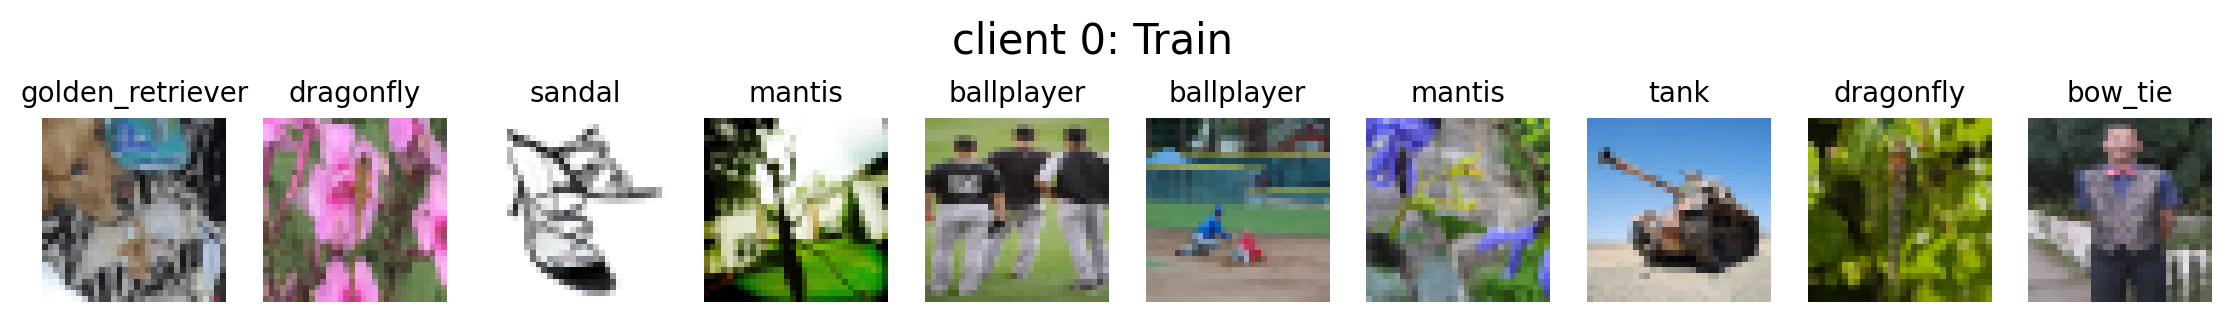

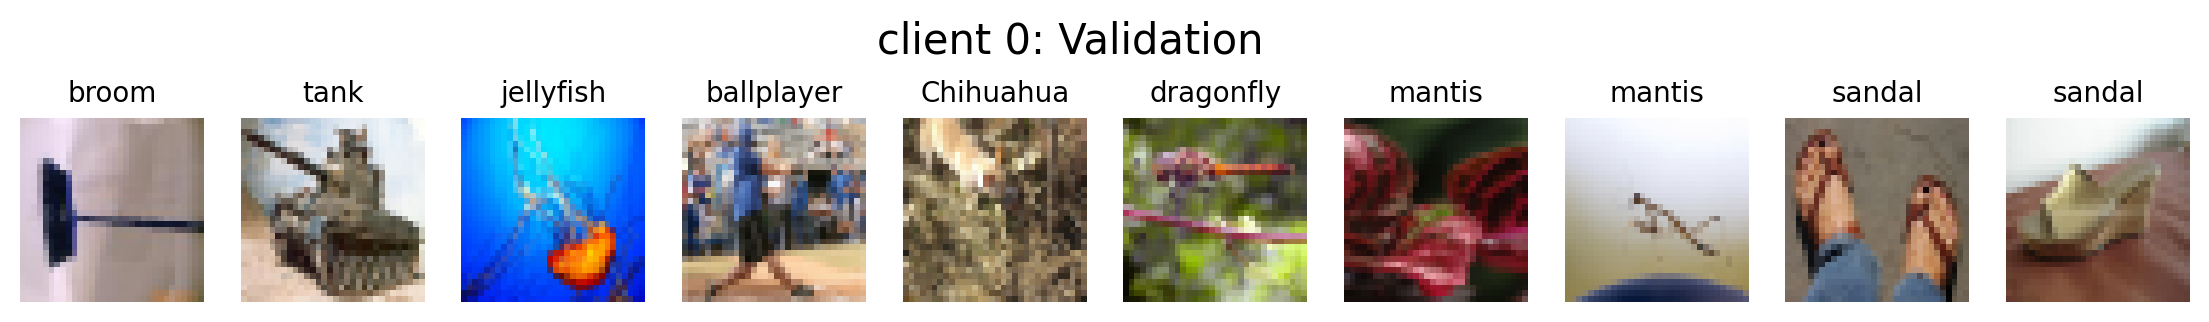

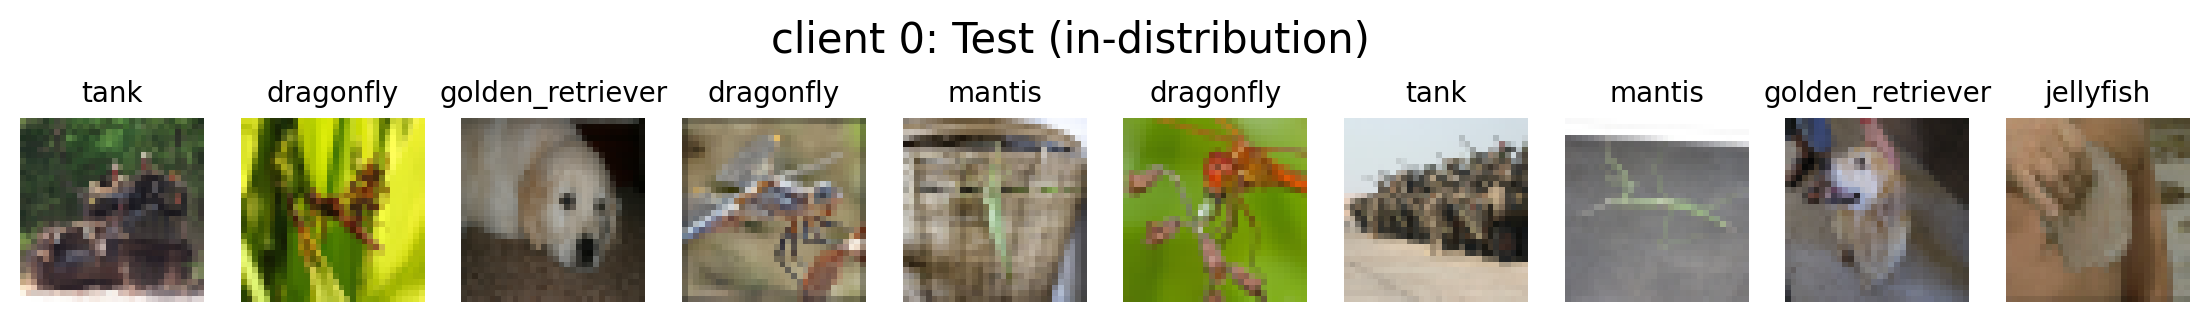

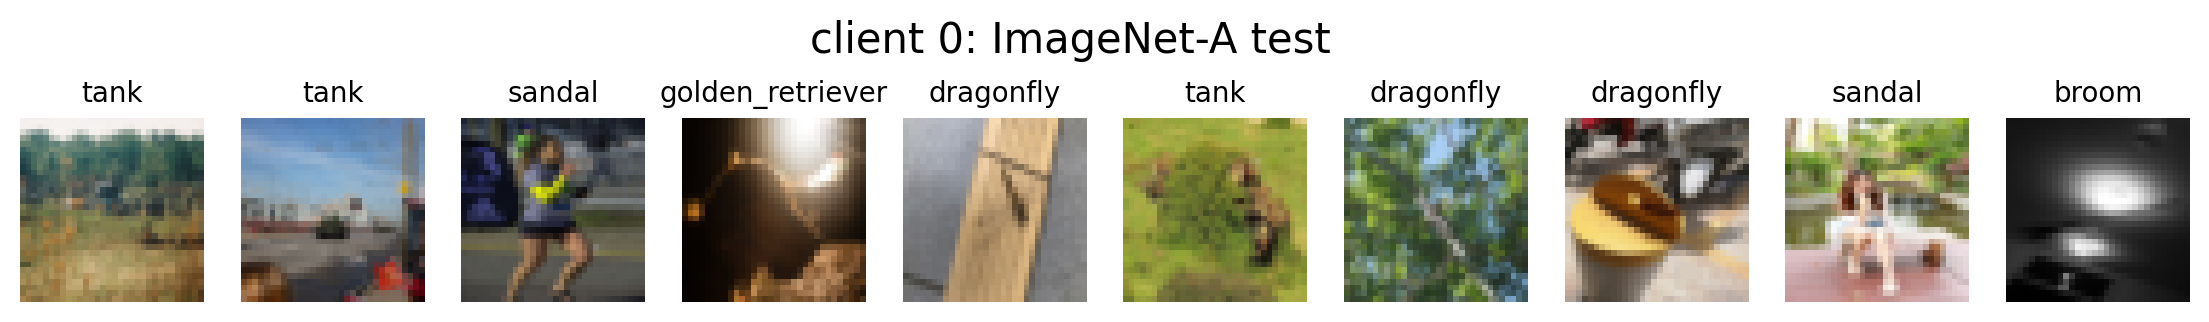

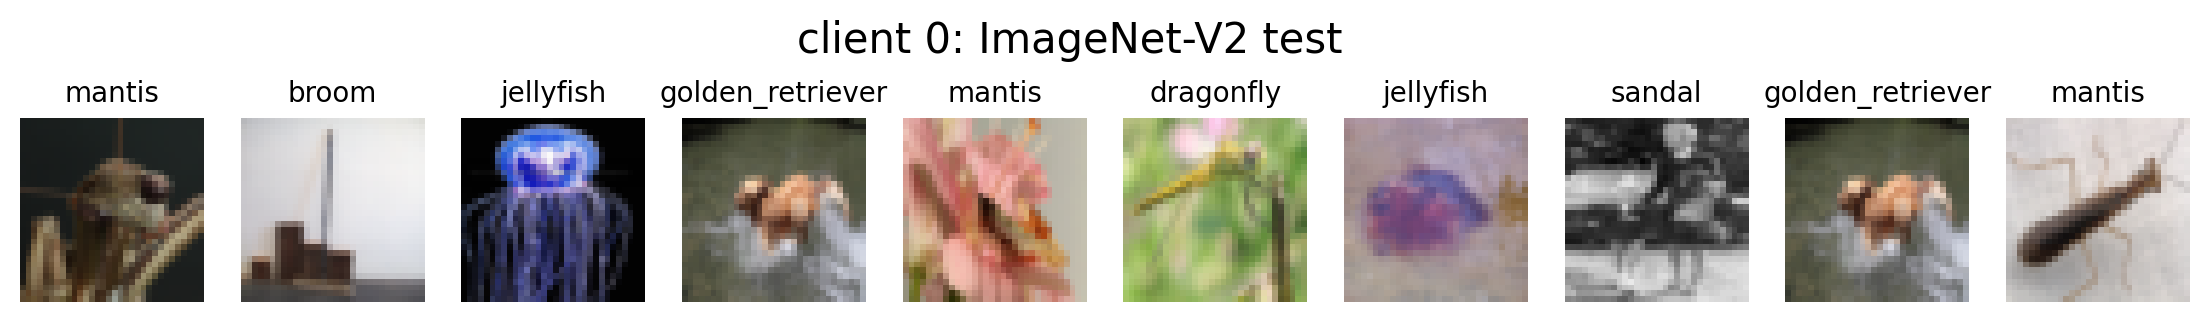

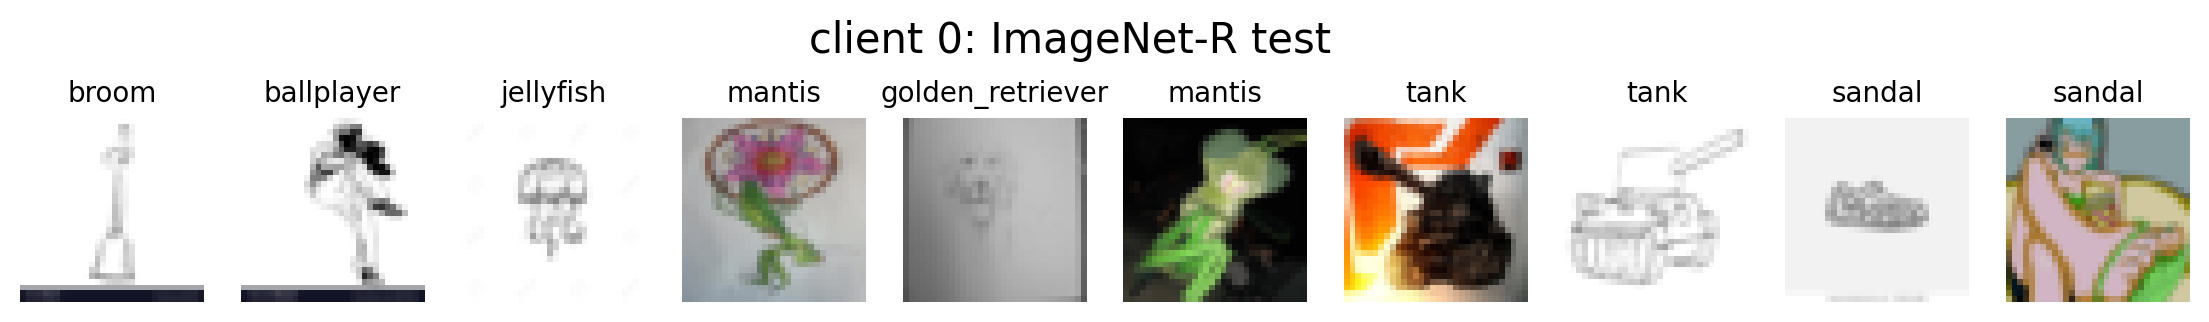

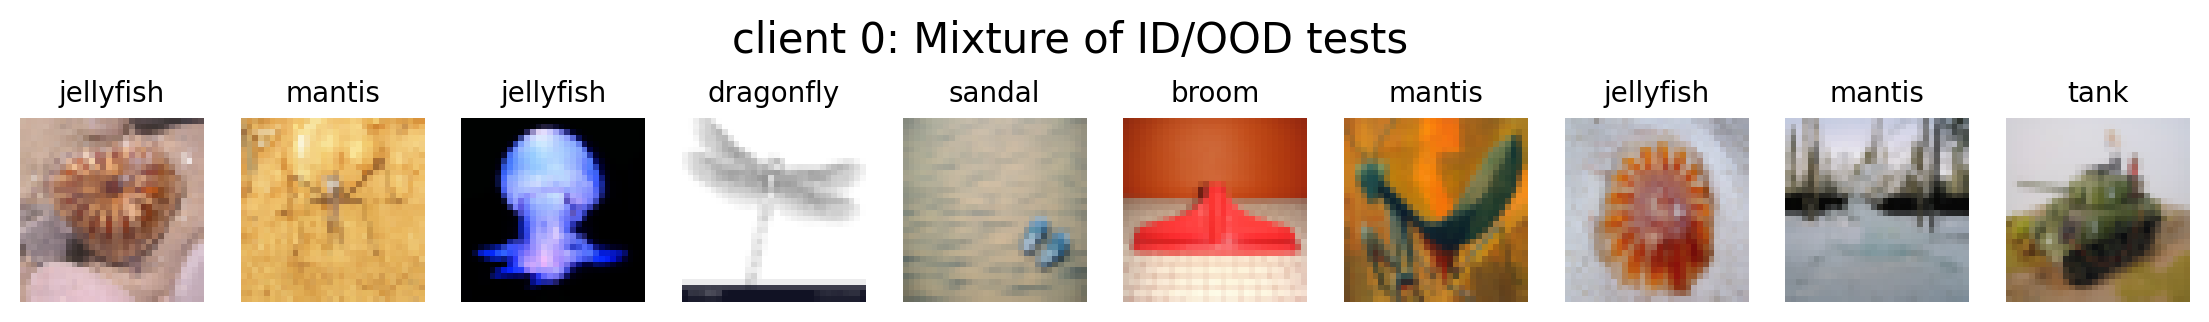

In [19]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

plot_train_test_split(0)